# Notebook for processing MPMS data from the IRM


In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy import interpolate

from IPython.display import display

** The data is written in sequence, the time stamp with each measurement is in sec
we need to convert moment from emu to Am2 
we need to use Temperature (K) and moment (converted to Am2)
we need to normalize the moment - to divide the moment measurement by mass of the specimen, "magnetization" 

starting row 1155 X measurment begins, there are 5 columns for different frequencies 
and we need to calculate the X since only M and H are measured 
we'd like to look at X' (in phase) and X'' (out of phase) susceptibility
usually X' is >> X''
total X * cos(theata - phase angle) = in phase
total X * sin(theta) = out of phase
total X = sqrt(in phase^2 + out of phase^2)
**

## functions for reading and ploting MPMS data

In [2]:
def read_MPMS3_files(path, spec_mass, header=44):
    '''
    path is path to the MPMS3 file
    spec_mass is in kg
    header is the header rows to skip
    sus_row_num is the row number in the original file that sus measurements start
    '''
    
    sus_row_num=0
    
    MPMS_file = pd.read_csv(path, header=header)

    if MPMS_file['AC Moment (emu)'][header:].dropna().empty == False: # this means there is sus
        sus_row_num = MPMS_file['AC Moment (emu)'].size-MPMS_file['AC Moment (emu)'].dropna().size
#         print(sus_row_num)

        X_row_start_num = sus_row_num

        FCZFCRTSIRM_data = MPMS_file.iloc[:X_row_start_num].reset_index(drop=1)
        FCZFCRTSIRM_data['Moment (Am2)'] = FCZFCRTSIRM_data['Moment (emu)']/1e3
        FCZFCRTSIRM_data['Magnetization (Am2/kg)'] = FCZFCRTSIRM_data['Moment (Am2)']/spec_mass


        sus_data = MPMS_file.iloc[X_row_start_num:].reset_index(drop=1)
        sus_data['AC Susceptibility SI'] = sus_data['AC Susceptibility (emu/Oe)']/spec_mass
        sus_data['AC X in phase SI'] = sus_data[sus_data.columns[21]]/spec_mass
        sus_data['AC X out phase SI'] = sus_data[sus_data.columns[23]]/spec_mass
        sus_data['AC X std perc'] = sus_data['AC Suscept. Std Err. (emu/Oe)']/sus_data['AC Susceptibility (emu/Oe)']*100
        
        
        return FCZFCRTSIRM_data, sus_data
    
    else: # there is no sus

        FCZFCRTSIRM_data = MPMS_file
        FCZFCRTSIRM_data['Moment (Am2)'] = FCZFCRTSIRM_data['Moment (emu)']/1e3
        FCZFCRTSIRM_data['Magnetization (Am2/kg)'] = FCZFCRTSIRM_data['Moment (Am2)']/spec_mass
        
        return FCZFCRTSIRM_data

def plot_MPMS_cycles(FCZFCRTSIRM_data, markersize=8, ls='-', labelpad=10,
                     step_labels=['FC', 'ZFC', 'RT-SIRM cooling', 'RT-SIRM warming'], 
                     step_colors=['blue', 'red', 'black', 'green']):
    # use unique zero field values to parse sequences
    zero_fields_list = FCZFCRTSIRM_data['Magnetic Field (Oe)'].unique()
#     print(zero_fields_list)
    FC = FCZFCRTSIRM_data[FCZFCRTSIRM_data['Magnetic Field (Oe)']==zero_fields_list[0]].iloc[1:].reset_index(drop=1)
    ZFC = FCZFCRTSIRM_data[FCZFCRTSIRM_data['Magnetic Field (Oe)']==zero_fields_list[1]].iloc[1:].reset_index(drop=1)
    RTSIRM = FCZFCRTSIRM_data[FCZFCRTSIRM_data['Magnetic Field (Oe)']==zero_fields_list[2]].reset_index(drop=1)
    
    # use temperature changes to parse out RT SIRM cooling and warming
    RTSIRM['coolorwarm'] = np.array(np.insert((np.diff(RTSIRM['Temperature (K)']) > 0 )* 1, 0, 0))
    RTSIRM_cooling = RTSIRM[RTSIRM['coolorwarm']==0].reset_index(drop=1)
    RTSIRM_warming = RTSIRM[RTSIRM['coolorwarm']==1].reset_index(drop=1)
    
    cycles = {'FC':FC, 
              'ZFC':ZFC, 
              'RT-SIRM cooling':RTSIRM_cooling, 
              'RT-SIRM warming':RTSIRM_warming}
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    for step_label, step_color in zip(step_labels, step_colors):
#         ax.scatter(cycles[step_label]['Temperature (K)'], cycles[step_label]['Magnetization (Am2/kg)'], 
#                    s=markersize, color=step_color, label=step_label)
        
        ax.plot(cycles[step_label]['Temperature (K)'], cycles[step_label]['Magnetization (Am2/kg)'], 
                ls=ls, color=step_color, label=step_label)
    ax.set_xlabel('Temperature (K)', fontsize=14, labelpad=labelpad)
    ax.set_ylabel('Magnetization (Am$^2/kg$)', fontsize=14, labelpad=labelpad)
    
    return ax

def plot_FCZFC_cycles(FCZFCRTSIRM_data, take_derivative=True, markersize=8, ls='-', labelpad=10,
                     step_labels=['FC', 'ZFC'], 
                     step_colors=['blue', 'red']):
    # use unique zero field values to parse sequences
    zero_fields_list = FCZFCRTSIRM_data['Magnetic Field (Oe)'].unique()

    FC = FCZFCRTSIRM_data[FCZFCRTSIRM_data['Magnetic Field (Oe)']==zero_fields_list[0]].reset_index(drop=1)
    ZFC = FCZFCRTSIRM_data[FCZFCRTSIRM_data['Magnetic Field (Oe)']==zero_fields_list[1]].reset_index(drop=1)
    
    cycles = {'FC':FC, 
              'ZFC':ZFC}
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    for step_label, step_color in zip(step_labels, step_colors):
        
        ax.plot(cycles[step_label]['Temperature (K)'], cycles[step_label]['Magnetization (Am2/kg)'], 
                ls=ls, color=step_color, label=step_label)
        if take_derivative:
            ax.plot(cycles[step_label]['Temperature (K)'][1:], 
                    np.diff(cycles[step_label]['Magnetization (Am2/kg)'])/np.diff(cycles[step_label]['Temperature (K)']), 
                ls=ls, color=step_color, label=step_label+' derivative')
            
    ax.set_xlabel('Temperature (K)', fontsize=14, labelpad=labelpad)
    ax.set_ylabel('Magnetization (Am$^2/kg$)', fontsize=14, labelpad=labelpad)
    
    return ax

def plot_RTSIRM_cycles(FCZFCRTSIRM_data, take_derivative=True, 
                       der_offset=0, der_scale=1, markersize=8, ls='-', labelpad=10,
                       step_labels=['RT-SIRM cooling', 'RT-SIRM warming'], 
                       step_colors=['black', 'green']):
    
    zero_fields_list = FCZFCRTSIRM_data['Magnetic Field (Oe)'].unique()
    RTSIRM = FCZFCRTSIRM_data[FCZFCRTSIRM_data['Magnetic Field (Oe)']==zero_fields_list[2]].reset_index(drop=1)
    
    # use temperature changes to parse out RT SIRM cooling and warming
    RTSIRM['coolorwarm'] = np.array(np.insert((np.diff(RTSIRM['Temperature (K)']) > 0 )* 1, 0, 0))
    RTSIRM_cooling = RTSIRM[RTSIRM['coolorwarm']==0].reset_index(drop=1)
    RTSIRM_warming = RTSIRM[RTSIRM['coolorwarm']==1].reset_index(drop=1)
    
    cycles = {'RT-SIRM cooling':RTSIRM_cooling, 
              'RT-SIRM warming':RTSIRM_warming}
    
    fig, ax = plt.subplots(figsize=(8,8))
    for step_label, step_color in zip(step_labels, step_colors):
        this_cycle = cycles[step_label]
#         print(this_cycle['Magnetization (Am2/kg)'], this_cycle['Temperature (K)'])
        ax.plot(this_cycle['Temperature (K)'].dropna().tolist(), this_cycle['Magnetization (Am2/kg)'].dropna().tolist(), 
                ls=ls, color=step_color, label=step_label)
        if take_derivative:
            
            der=np.diff(this_cycle['Magnetization (Am2/kg)'].dropna().tolist())/np.diff(this_cycle['Temperature (K)'].dropna().tolist())
            normalized_der = der*der_scale+der_offset
#             print(np.mean(der), RTSIRM['Magnetization (Am2/kg)'].dropna(), RTSIRM['Magnetization (Am2/kg)'].dropna().min())
            ax.plot(cycles[step_label]['Temperature (K)'][1:], 
                    normalized_der, 
                ls='--', color=step_color, alpha=0.6, label=step_label+' derivative')

    ax.set_xlabel('Temperature (K)', fontsize=14, labelpad=labelpad)
    ax.set_ylabel('Magnetization (Am$^2/kg$)', fontsize=14, labelpad=labelpad)
    
    return ax

## function for plotting MPMS AC sus data

In [3]:
def plot_sus(sus_data, alpha=0.6, labelpad=10):
    AC_frequencies = sus_data['AC Frequency (Hz)'].unique()[:4]
#     print(AC_frequencies)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(8,32), nrows=4, ncols=1)
    for i, f in enumerate(AC_frequencies):
        print(f)
        this_sus = sus_data[sus_data['AC Frequency (Hz)']==f].reset_index(drop=1)
        ax1.scatter(this_sus['Temperature (K)'], this_sus['AC Susceptibility SI'], color = 'C'+str(i), alpha=alpha)
        ax1.plot(this_sus['Temperature (K)'], this_sus['AC Susceptibility SI'], color = 'C'+str(i), label=str(round(f))+' Hz', alpha=alpha)
        
        
        
        ax2.scatter(this_sus['Temperature (K)'], this_sus['AC X in phase SI'], color = 'C'+str(i), alpha=alpha)
        ax2.plot(this_sus['Temperature (K)'], this_sus['AC X in phase SI'], color = 'C'+str(i), label=str(round(f))+' Hz', alpha=alpha)
        
        
        ax3.scatter(this_sus['Temperature (K)'], this_sus['AC X out phase SI'], color = 'C'+str(i), alpha=alpha)
        ax3.plot(this_sus['Temperature (K)'], this_sus['AC X out phase SI'], color = 'C'+str(i), label=str(round(f))+' Hz', alpha=alpha)
        
        
        ax4.scatter(this_sus['Temperature (K)'], this_sus['AC X std perc'], color = 'C'+str(i), alpha=alpha)
        ax4.plot(this_sus['Temperature (K)'], this_sus['AC X std perc'], color = 'C'+str(i), label=str(round(f))+' Hz', alpha=alpha)
    
    ax1.set_title('total $\chi$', fontsize=16)
    ax2.set_title('in phase $\chi$', fontsize=16)
    ax3.set_title('out of phase $\chi$', fontsize=16)
    ax4.set_title('total $\chi$ std', fontsize=16)
    
    ax1.set_ylim(sus_data['AC Susceptibility SI'].min()*0.9, sus_data['AC Susceptibility SI'].max()*1.05)
    ax2.set_ylim(sus_data['AC X in phase SI'].min()*0.8, sus_data['AC X in phase SI'].max()*1.05)
    ax3.set_ylim(max(sus_data['AC X out phase SI'].min(),0), sus_data['AC X out phase SI'].max()*1.05)
    ax4.set_ylim(sus_data['AC X std perc'].min(), sus_data['AC X std perc'].max()*1.05)
    
    ax1.set_xlabel('Temperature (K)', fontsize=16, labelpad=labelpad)
    ax2.set_xlabel('Temperature (K)', fontsize=16, labelpad=labelpad)
    ax3.set_xlabel('Temperature (K)', fontsize=16, labelpad=labelpad)
    ax4.set_xlabel('Temperature (K)', fontsize=16, labelpad=labelpad)
    
    ax1.set_ylabel('$\chi \ total\ (10^{-6}m^3/kg$)', fontsize=16, labelpad=labelpad)
    ax2.set_ylabel('$\chi \ in\ phase \ (10^{-6}m^3/kg$)', fontsize=16, labelpad=labelpad)
    ax3.set_ylabel('$\chi \ out\ of\ phase \ (10^{-6}m^3/kg$)', fontsize=16, labelpad=labelpad)
    ax4.set_ylabel('$\chi_{std}$ (%)', fontsize=16)
    
    ax1.legend(fontsize=12)
    ax2.legend(fontsize=12)
    ax3.legend(fontsize=12)
    ax4.legend(fontsize=12)
    
    fig.subplots_adjust(hspace=0.3)
    
#     ax.set_ylabel('$\chi \ total\ (10^{-6}m^3/kg$)', fontsize=16)
    return ax1, ax2, ax3, ax4

## read in file and do unit conversions

### DA2-r

In [4]:
DA2_r_FCZFCRTSIRM, DA2_r_sus = read_MPMS3_files('../data/Rock_mag_data/MPMS3/DA2-R-FC-ZFC-RT-SIRM-AC_sweep.dat', 0.1808/1e3)

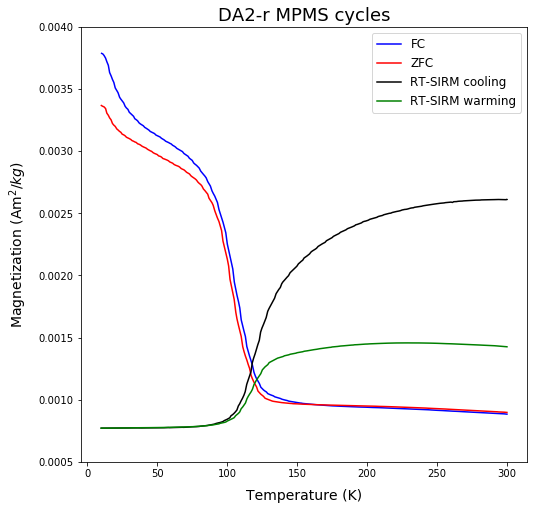

In [5]:
DA2_r_ax = plot_MPMS_cycles(DA2_r_FCZFCRTSIRM)
DA2_r_ax.set_ylim(0.0005, 0.004)
DA2_r_ax.set_title('DA2-r MPMS cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DA2_r_MPMS_plot.png', dpi=300, bbox_inches='tight')
plt.show()

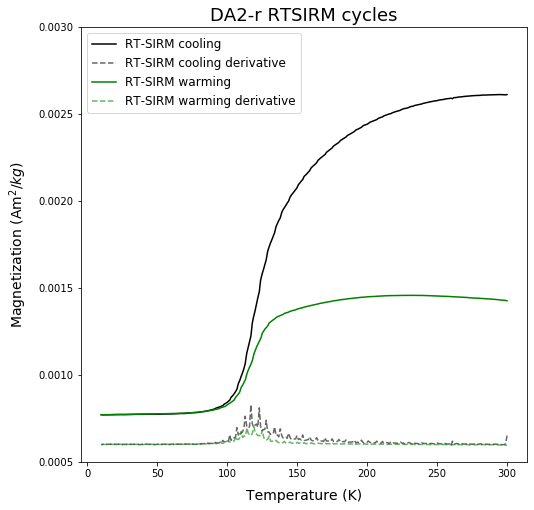

In [6]:
DA2_r_RTSIRM_ax = plot_RTSIRM_cycles(DA2_r_FCZFCRTSIRM, der_offset=0.0006, der_scale=3)
DA2_r_RTSIRM_ax.set_ylim(0.0005, 0.003)
DA2_r_RTSIRM_ax.set_title('DA2-r RTSIRM cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DA2_r_RTSIRM_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### DA4_r (same as DA4_A)

In [7]:
DA4_r_FCZFCRTSIRM, DA4_r_sus = read_MPMS3_files('../data/Rock_mag_data/MPMS3/DA4-A-FC-ZFC-RT-SIRM-AC_sweep.dat', 0.188/1e3, )

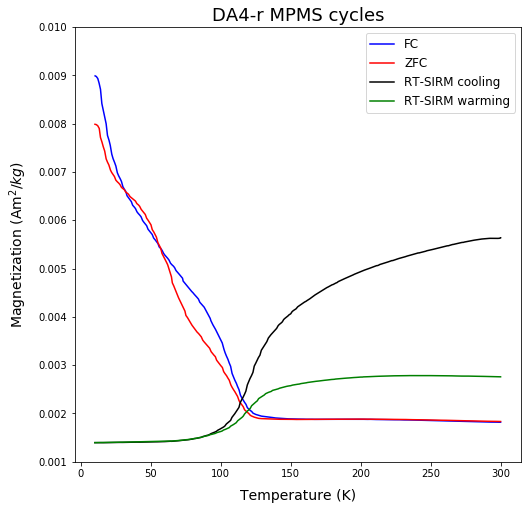

In [8]:
DA4_r_ax = plot_MPMS_cycles(DA4_r_FCZFCRTSIRM)
DA4_r_ax.set_ylim(0.001, 0.01)
DA4_r_ax.set_title('DA4-r MPMS cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DA4_r_MPMS_plot.png', dpi=300, bbox_inches='tight')
plt.show()

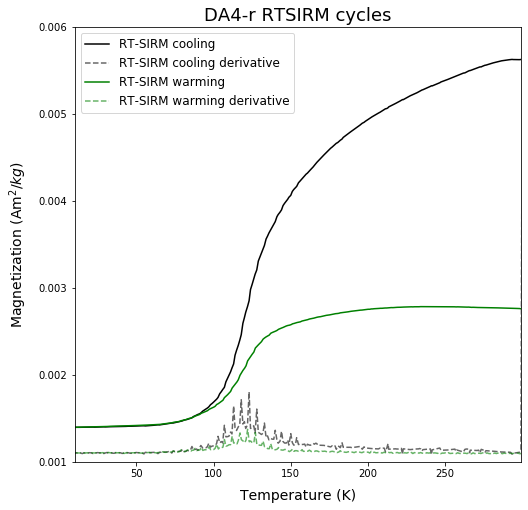

In [9]:
DA4_r_RTSIRM_ax = plot_RTSIRM_cycles(DA4_r_FCZFCRTSIRM, der_offset=0.0011, der_scale=5)
DA4_r_RTSIRM_ax.set_xlim(10, 299)
DA4_r_RTSIRM_ax.set_ylim(0.001, 0.006)

DA4_r_RTSIRM_ax.set_title('DA4-r RTSIRM cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DA4_r_RTSIRM_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### DX1-1r

In [10]:
DX1_1r_FCZFCRTSIRM = read_MPMS3_files('../data/Rock_mag_data/MPMS3/DX1-1r-FC-ZFC-RT-SIRM-VSM-SWEEP.dat', 0.31706/1e3, )

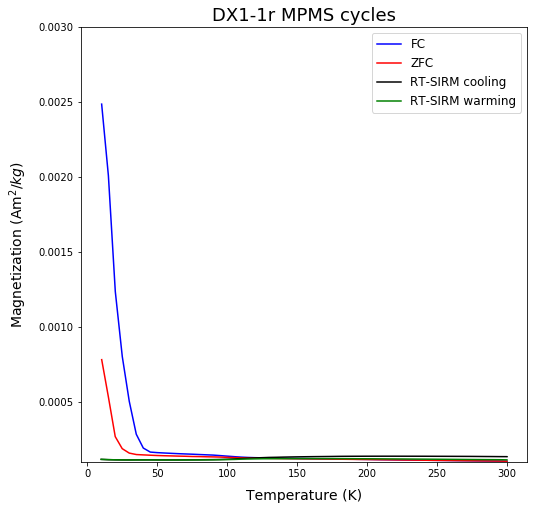

In [11]:
DX1_1r_ax = plot_MPMS_cycles(DX1_1r_FCZFCRTSIRM)
DX1_1r_ax.set_ylim(0.0001, 0.003)
DX1_1r_ax.set_title('DX1-1r MPMS cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DX1_1r_MPMS_plot.png', dpi=300, bbox_inches='tight')
plt.show()

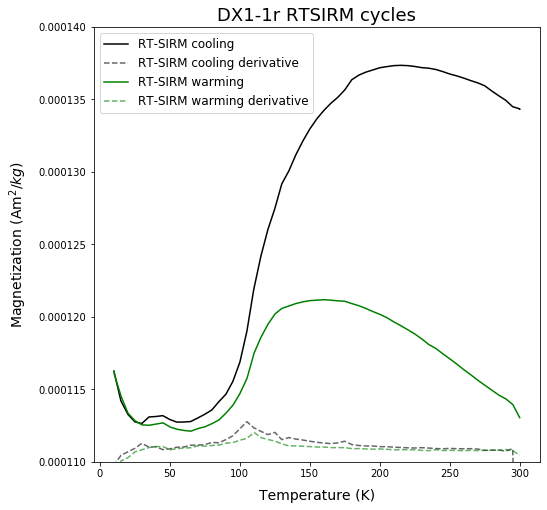

In [12]:
DX1_1r_RTSIRM_ax = plot_RTSIRM_cycles(DX1_1r_FCZFCRTSIRM, der_scale=3, der_offset=0.000111)
DX1_1r_RTSIRM_ax.set_ylim(0.00011, 0.00014)
DX1_1r_RTSIRM_ax.set_title('DX1-1r RTSIRM cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DX1_1r_RTSIRM_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### DX1-4r

In [ ]:
DX1_4r_FCZFCRTSIRM, DX1_4r_sus = read_MPMS3_files('../data/Rock_mag_data/MPMS3/DX1-4r-FC-ZFC-RT-SIRM-VSM-SWEEP_AC-3freq.dat', 0.0777/1e3)

In [ ]:
DX1_4r_ax = plot_MPMS_cycles(DX1_4r_FCZFCRTSIRM)
DX1_4r_ax.set_ylim(0.0001, 0.0006)
DX1_4r_ax.set_title('DX1-4r MPMS cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DX1_4r_MPMS_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
DX1_4r_RTSIRM_ax = plot_RTSIRM_cycles(DX1_4r_FCZFCRTSIRM, der_scale=3, der_offset=0.000142)
DX1_4r_RTSIRM_ax.set_ylim(0.00014, 0.00022)
DX1_4r_RTSIRM_ax.set_title('DX1-4r RTSIRM cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DX1_4r_RTSIRM_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### DX1-5r

In [ ]:
DX1_5r_FCZFCRTSIRM, DX1_5r_sus = read_MPMS3_files('../data/Rock_mag_data/MPMS3/DX1-5r-FC-ZFC-RT-SIRM-VSM-SWEEP_AC-3freq.csv', 0.07986/1e3)

In [ ]:
DX1_5r_ax = plot_MPMS_cycles(DX1_5r_FCZFCRTSIRM)
DX1_5r_ax.set_ylim(0.0001, 0.0005)
DX1_5r_ax.set_title('DX1-5r MPMS cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DX1_5r_MPMS_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
DX1_5r_RTSIRM_ax = plot_RTSIRM_cycles(DX1_5r_FCZFCRTSIRM, der_scale=3, der_offset=0.000124)
DX1_5r_RTSIRM_ax.set_ylim(0.00012, 0.000238)
DX1_5r_RTSIRM_ax.set_title('DX1-5r RTSIRM cycles', fontsize=18)
plt.legend(fontsize=12)
plt.savefig('code_output/DX1_5r_RTSIRM_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## now let's load T-X file

In [ ]:
def get_high_T_X_data(excel_sheet, specimen_index):
    Tlist = excel_sheet.iloc[:,0 + specimen_index * 3][2:].dropna().tolist() # temperature list
    Xlist = excel_sheet.iloc[:,1 + specimen_index * 3][2:].dropna().tolist() # Chi list
    Xlist = [1e6*i for i in Xlist] # make unit to be 1e-6m3/kg
    
    warmorcool = np.array(np.insert((np.diff(Tlist) > 0 )* 1, 0, 1))
#     print(warmorcool)
    warm_T = [Tlist[i] for i in range(len(warmorcool)) if warmorcool[i]==1]
    cool_T = [Tlist[i] for i in range(len(warmorcool)) if warmorcool[i]==0]
    warm_X = [Xlist[i] for i in range(len(warmorcool)) if warmorcool[i]==1]
    cool_X = [Xlist[i] for i in range(len(warmorcool)) if warmorcool[i]==0]
    
    specimen_name = excel_sheet.columns[1 + specimen_index * 3]
    return {'Tlist':Tlist, 'Xlist':Xlist, 
            'warm_T':warm_T, 'warm_X':warm_X, 
            'cool_T':cool_T, 'cool_X':cool_X, 
            'Name':specimen_name}

def plot_high_T_X_data(excel_sheet, holder_index, spec_mass=1, specimen_index=-1, is_holder=False, kind='linear'):
    holder_data = get_high_T_X_data(excel_sheet, holder_index)
    holder_Tlist = holder_data['Tlist']
#     holder_Xlist = [1000*i for i in holder_data['Xlist']]
    holder_Xlist = holder_data['Xlist']
    new_T = np.linspace(min(holder_Tlist), max(holder_Tlist))
    f = interpolate.interp1d(holder_Tlist, holder_Xlist, kind=kind, fill_value='extrapolate')
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    if is_holder:
        ax.scatter(holder_Tlist, holder_Xlist, color='gray', s=5, label='holder')
        ax.plot(new_T, f(new_T), color='gray', ls='--', label='interpolated holder')
        ax.set_ylim(min(holder_Xlist), max(holder_Xlist))
        ax.set_title('holder high T-X', fontsize=14)
        ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
        ax.set_ylabel('$\chi \ 10^{-6}m3/kg$', fontsize=14)
        ax.legend(fontsize=14)
        return ax
    if specimen_index!=-1:
        this_spec_data = get_high_T_X_data(excel_sheet, specimen_index)
        Tlist = this_spec_data['Tlist']
        Xlist = np.array(this_spec_data['Xlist'])
        corrected_Xlist = np.array(Xlist)-f(Tlist)*1000/spec_mass
        
        warm_T = this_spec_data['warm_T']
        warm_X = np.array(this_spec_data['warm_X'])
        
        cool_T = this_spec_data['cool_T']
        cool_X = np.array(this_spec_data['cool_X'])
        
        spec_name = this_spec_data['Name']
        
        ax.scatter(warm_T, warm_X, color='r', s=5, alpha=0.5, label='uncorrected warming')
        ax.scatter(cool_T, cool_X, color='b', s=5, alpha=0.5, label='uncorrected cooling')
        
#         print(warm_X, f(np.array(warm_T)))
#         print([T for T in warm_T])
#         print([f(T) for T in warm_T])
#         print(warm_T)
        corrected_warm_X = np.array(warm_X)-f(warm_T)*1000/spec_mass
        corrected_cool_X = np.array(cool_X)-f(cool_T)*1000/spec_mass

        ax.scatter(warm_T, corrected_warm_X, color='r', s=5)      
        ax.plot(warm_T, corrected_warm_X, color='r', label='corrected warming')
        
        ax.scatter(cool_T, corrected_cool_X, color='b', s=5)
        ax.plot(cool_T, corrected_cool_X, color='b', label='corrected cooling')

        ax.set_ylim(min(min(corrected_Xlist),0), max(corrected_Xlist))
#     ax.plot()
        ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
        ax.set_ylabel('$\chi \ 10^{-6}m^3/kg$', fontsize=14)
    
        ax.set_title(spec_name+' high T-X', fontsize=14)
        ax.legend(fontsize=14)
        return ax, warm_T, corrected_warm_X, cool_T, corrected_cool_X

In [ ]:
# Loading IRM data file
rockmag_data = pd.ExcelFile('../data/Rock_mag_data/SSRM2022C_IRMDB_export.xlsx')
# specimen_info = pd.read_excel(rockmag_data, 'Specimen Info')
high_T_X_measurements = pd.read_excel(rockmag_data, 'high_T susceptibility')

high_T_X_measurements

## blank holder measurement and interpolate

In [ ]:
blank_ax2 = plot_high_T_X_data(high_T_X_measurements, 1, is_holder=True)

# blank_ax1.set_ylim(-1e-9, 1e-9)

### DA4-r

In [ ]:
DA4_r_ax, DA4_r_warm_T, DA4_r_corrected_warm_X, DA4_r_cool_T, DA4_r_corrected_cool_X = plot_high_T_X_data(high_T_X_measurements, 
                                                                                                          1, 
                                                                                                          spec_mass=0.188, 
                                                                                                          specimen_index=2, 
                                                                                                          kind='nearest', 
                                                                                                          )

DA4_r_ax.set_ylim(-5e-2, 1.2)
plt.savefig('code_output/DA4_r_high_T_X.png', dpi=300, bbox_inches='tight')

# blank_ax1.set_ylim(-1e-9, 1e-9)
plt.show()

In [ ]:
_, _,_,_ = plot_sus(DA4_r_sus)

plt.savefig('code_output/DA4_r_MPMS_AC_sus.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

DA4_r_warm_T, DA4_r_corrected_warm_X, DA4_r_cool_T, DA4_r_corrected_cool_X

high_T_norm_factor = np.hstack([DA4_r_corrected_warm_X,DA4_r_corrected_cool_X])[np.argmin(np.hstack([DA4_r_warm_T, DA4_r_cool_T]))]

DA4_r_corrected_warm_X_norm = DA4_r_corrected_warm_X/high_T_norm_factor
DA4_r_corrected_cool_X_norm = DA4_r_corrected_cool_X/high_T_norm_factor

ax.scatter(DA4_r_warm_T, DA4_r_corrected_warm_X_norm, c='r', s=5)
ax.plot(DA4_r_warm_T, DA4_r_corrected_warm_X_norm, c='r', label='RT warming')

# ax.scatter(DA4_r_cool_T, DA4_r_corrected_cool_X_norm, c='b', s=5)
# ax.plot(DA4_r_cool_T, DA4_r_corrected_cool_X_norm, c='b', label='normalized RT cooling')

alpha=1
K_to_C = 273
DA4_r_AC_frequencies = DA4_r_sus['AC Frequency (Hz)'].unique()[:4]
    

for i, f in enumerate(DA4_r_AC_frequencies):
    this_sus = DA4_r_sus[DA4_r_sus['AC Frequency (Hz)']==f].reset_index(drop=1)
    this_X_normalize = this_sus['AC Susceptibility SI'][this_sus['Temperature (K)'].argmax()]
    ax.scatter(this_sus['Temperature (K)']-K_to_C, 
                     this_sus['AC Susceptibility SI']/this_X_normalize, 
                     s=5, color = 'C'+str(i), alpha=alpha)
    ax.plot(this_sus['Temperature (K)']-K_to_C, 
                  this_sus['AC Susceptibility SI']/this_X_normalize, 
                  color = 'C'+str(i), label='LT '+str(round(f))+' Hz', alpha=alpha)
ax.set_ylabel('Normalized susceptibility', fontsize=14)    
ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
ax.set_title('DA4-r full temperature range X-T plot', fontsize=18)
plt.legend(fontsize=14)
plt.savefig('code_output/DA4_r_full_temp_T_X.png', dpi=300, bbox_inches='tight')
plt.show()

kind : str or int, optional
    Specifies the kind of interpolation as a string
    ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
    'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
    refer to a spline interpolation of zeroth, first, second or third
    order; 'previous' and 'next' simply return the previous or next value
    of the point) or as an integer specifying the order of the spline
    interpolator to use.
    Default is 'linear'.

In [ ]:
DX1_4r_ax, DX1_4r_warm_T, DX1_4r_corrected_warm_X, DX1_4r_cool_T, DX1_4r_corrected_cool_X  = plot_high_T_X_data(high_T_X_measurements, 
                                                                                                                1, 
                                                                                                                spec_mass=0.0777, 
                                                                                                                specimen_index=3, kind='nearest')
DX1_4r_ax.set_ylim(-0.15, .05)
plt.savefig('code_output/DX1_4r_high_T_X.png', dpi=300, bbox_inches='tight')

In [ ]:
DX1_4r2_ax, DX1_4r2_warm_T, DX1_4r2_corrected_warm_X, DX1_4r2_cool_T, DX1_4r2_corrected_cool_X  = plot_high_T_X_data(high_T_X_measurements, 
                                                                                                                1, 
                                                                                                                spec_mass=0.49788, 
                                                                                                                specimen_index=4, kind='nearest')
DX1_4r_ax.set_ylim(-0.15, .05)
plt.savefig('code_output/DX1_4r2_high_T_X.png', dpi=300, bbox_inches='tight')

# blank_ax1.set_ylim(-1e-9, 1e-9)